# Fitting energy resolutions

In [1]:
import geeksw.hgcal.testbeam as hgc
import numpy as np
import matplotlib.pyplot as plt
from geeksw.fitting.functions import crystalball, gausexp, gaus
from geeksw.utils import effrms
from scipy.optimize import curve_fit

Let's select a high energy electron run from the first configuration, where the reconstructed energy is not so precise as with configuration 2. This way, the problematic of the left tail gets  clear.

In [2]:
hgc.runlist.query("Particle == 'electron' and CaloConfiguration == 1 and Energy == 300").head(1)

,Run,Date,Nevents,Particle,Energy,Configuration,CaloConfiguration
152,405,2018-10-13 15:07:00,10300,electron,300,22b,1


In [3]:
df = hgc.load_run(405, columns=["event", "rechit_energy", "rechit_layer"])

We calculate the energy sums in the electromagnetic calorimeter part:

In [128]:
energy_sums = df.query("rechit_layer <= 28").groupby("event")["rechit_energy"].sum().values

Little helper function to convert bin edges to bin centers:

In [129]:
def edges2centers(bin_edges):
    return (bin_edges[1:] + bin_edges[:-1])/2.

We turn the energy sums data into a hitogram, also calculating Poissonian errors ($\sqrt{n}$ for each bin):

In [130]:
bins = np.linspace(20000, 29000, 50)
counts, bin_edges = np.histogram(energy_sums, bins=bins)
counts = np.array(counts, dtype=np.float)
counts_uncert = np.sqrt(counts)
bin_centers = edges2centers(bin_edges)

The energy values and counts should be normalized, then the fits converge easier even without apporpriate starting parameters:

In [131]:
scale = np.median(energy_sums)
bin_edges = bin_edges / scale
bin_centers = bin_centers / scale
counts_uncert = counts_uncert / np.sum(counts)
counts = counts / np.sum(counts)

We define a little function to fit, plot, and return the parameters found by the fit. You can find the description of the fitting functions here: https://github.com/guitargeek/geeksw/blob/master/geeksw/fitting/functions.py

In [133]:
def plot_energy_sum_fit(f, **kwargs):
    popt, pcov = curve_fit(f, bin_centers, counts)
    plt.plot(bin_centers, f(bin_centers, *popt), **kwargs)
    return popt

Now, we fit the data with three different distributions. A simple Gaussian, a Gaussian with tail following a power law on the left (crystal ball), and a Gaussian with exponential left tail.

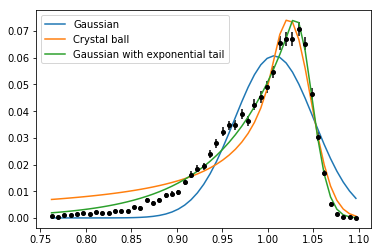

In [134]:
plt.errorbar(bin_centers, counts, yerr=counts_uncert, fmt='o', markersize=4, color='k')
popt_gaus = plot_energy_sum_fit(gaus, label="Gaussian")
popt_crystalball = plot_energy_sum_fit(crystalball, label="Crystal ball")
popt_gausexp = plot_energy_sum_fit(gausexp, label="Gaussian with exponential tail")
plt.legend(loc="upper left")
plt.show()

Whe extract the relative resolution estimate from the relevant parameters of each fitting function, and also compare this to the resolution estimate we obtain from the effective RMS of the energy sums.

In case of the effective RMS, the peak position as a proxy for $E$ is just the position of the bin with the most counts, as an estimate for the mode of the distribution.

In [135]:
res_gaus = popt_gaus[2]/popt_gaus[1]
res_crystalball = popt_crystalball[3]/popt_crystalball[2]
res_gausexp = popt_gausexp[2]/popt_gausexp[1]
res_effrms = effrms(energy_sums)/scale*bin_centers[np.argmax(counts)]

print("Resolution with Gaussian fit: {0:.3f} %".format(res_gaus))
print("Resolution with Crystal ball fit: {0:.3f} %".format(res_crystalball))
print("Resolution with Gaussian fit: {0:.3f} %".format(res_gausexp))
print("Resolution with effective RMS: {0:.3f} %".format(res_effrms))

Resolution with Gaussian fit: 0.043 %
Resolution with Crystal ball fit: 0.024 %
Resolution with Gaussian fit: 0.018 %
Resolution with effective RMS: 0.048 %


These are some quite different numbers! What do you think? Which of these values is the most appropriate when you want to quote a resoltion for the calorimeter?